In [1]:
# preprocess Links

In [2]:
# import spacy

# nlp = spacy.load('en_core_web_sm')

In [3]:
import requests
from bs4 import BeautifulSoup
import time

def get_clean_data(url):
    try :
        content = requests.get(url)
        content = content.text
        
    except(ConnectionError, Exception):
        content = ''
        
    bs = BeautifulSoup(content,'html.parser')
    texts = bs.findAll(['title','p','strong','li',re.compile('^h[1-6]$')])
    return texts


In [4]:
import re
def remove_tags(content):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', content)
    
    return cleantext

In [5]:
def remove_punctuation(content):
    content = re.sub("_", "", content)
    content = re.sub("[^\w\s]", "", content)
    content = re.sub(' +', ' ', content)
    content = re.sub("\n", "", content)
    return content

In [6]:
# def convert_to_vector(content,vocabulary):
#     vector_dict = dict.fromkeys(vocabulary,0)
#     doc = nlp(content)

#     for token in doc:
#         if token.text.lower() in vector_dict:
#             vector_dict[token.text.lower()] += 1
    
#     return vector_dict.values()

In [7]:
def create_vocabulary(list_of_queries):
    vocabulary = set()
    for query in list_of_queries:
        words = query.lower().split()
        vocabulary.update(words)
    
    return vocabulary   

In [8]:
import pandas as pd

In [9]:
dataset = pd.read_csv('Queries.csv', skipinitialspace = True, quotechar = '"')

In [10]:
vocab = create_vocabulary(list(set(dataset['Query'])))

In [11]:
from multiprocessing import  Pool
import numpy as np
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [12]:
def clean_url(df):
    df['text'] = df['URL'].apply(lambda x : remove_punctuation(remove_tags(str(get_clean_data(x)))).lower())
    return df

In [13]:
dataset_with_text = parallelize_dataframe(dataset,clean_url)

In [14]:
def bag_of_word_df(dataset, vocab):
    dataset = pd.concat([dataset,pd.DataFrame(columns=list(vocab))], sort=False)
    for feature in vocab:
        dataset[feature] = dataset['text'].apply(lambda x: x.count(' ' + feature + ' '))
    return dataset

In [15]:
vector_df = bag_of_word_df(dataset_with_text, vocab)

In [16]:
queries = set(vector_df.Query)

# Query Likelihood Evaluation Baseline

In [17]:
import numpy as np
def get_likelihood_score(row, D):
    tot = 0
    for term in row['Query'].lower().split():
        tot += np.log((row[term] + 1) /(D+ len(row.keys())-1))
    return tot

In [18]:
vector_df['score'] = [get_likelihood_score(row,len(vector_df)) for ind, row in vector_df.iterrows()]

# NDCG Evaluation

In [19]:
def dcg(ranks, i):
    value = ranks[0]
    if i == 0:
        return value
    else:
        for x in range(1,i+1):
            value += (ranks[x])/(np.log2(x+1))
        return value

In [20]:
for query in queries:
    temp = vector_df[vector_df['Query'] == query].sort_values(by=['score'], ascending=False)[['Query','URL','score', 'Ranking']]
    
    # ----------------------------------
    y = [] 
    for x in range(len(temp)):
        y.append(x)
    temp['QL_rank'] = y
    
    # ----------------------------------
    dcg_values = [0]*len(temp)
    for i in range(len(temp)):
        dcg_values[i] = dcg(list(temp.Ranking), i)
    temp['DCG'] = dcg_values
    
    # ----------------------------------
    ideal = list(temp.Ranking)
    ideal.sort(reverse = True)
    dcg_ideal = [0]*len(temp)
    for j in range(len(temp)):
        dcg_ideal[j] = dcg(ideal, j)
    
    norm = [a/b for a,b in zip(dcg_values,dcg_ideal)]
    temp['NDCG'] = norm
    # ----------------------------------
    if query == 'Celtics 11/20/2019':
        temp.to_csv('Results/Celtic Query.csv')
    else:
        temp.to_csv('Results/' + str(query) + '.csv')


# Graphing Tool

In [21]:
import numpy as np
import matplotlib.pyplot as plt
def get_query_graph(dir_path):
    content = pd.read_csv(dir_path)
    query = (dir_path.split('/')[1].split('.')[0])
    plt.title("Query: " + str(query))
    plt.plot(range(1, len(content)+1),content['NDCG'], marker='o')
    plt.xticks(range(1, len(content)+1))
    plt.xlabel("Rank @N ")
    plt.ylabel("NDCG Value")

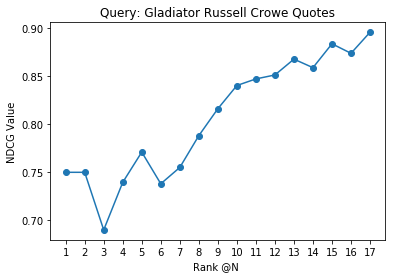

In [30]:
get_query_graph('Results/Gladiator Russell Crowe Quotes.csv')